# **Cell 1: Instalasi Library**

In [ ]:
!pip install langchain-community replicate pandas numpy tqdm python-dotenv matplotlib seaborn

import pandas as pd
import numpy as np
import os
import time
import json
import requests
from tqdm import tqdm
import logging
from dotenv import load_dotenv
import re
import matplotlib.pyplot as plt
import seaborn as sns
from langchain_community.llms import Replicate

print("✅ Semua library berhasil diimport!")

✅ Semua library berhasil diimport!


# **Cell 2: Setup Replicate API (Optimized dengan LangChain)**

In [ ]:
load_dotenv()

REPLICATE_API_TOKEN = os.getenv('REPLICATE_API_TOKEN')

if not REPLICATE_API_TOKEN:
    try:
        # Added newline character to the input prompt
        REPLICATE_API_TOKEN = input("Masukkan Replicate API Token Anda:\n").strip()
    except:
        print("Silakan set REPLICATE_API_TOKEN terlebih dahulu")

os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN

# Model configuration dengan parameter optimal
MODEL_NAME = "ibm-granite/granite-3.3-8b-instruct"

# Inisialisasi model dengan parameter optimized
granite_model = Replicate(
    model=MODEL_NAME,
    replicate_api_token=REPLICATE_API_TOKEN,
    model_kwargs={
        "max_new_tokens": 512,
        "temperature": 0.3,
        "top_p": 0.9,
        "top_k": 50,
        "repetition_penalty": 1.1
    }
)

print("✅ Replicate API berhasil terkoneksi dengan model Granite 3.3-8B!")

# **Cell 3: Memuat Data Hasil Preprocessing**

In [ ]:
try:
    df = pd.read_csv('/content/full_dataset_clean.csv')
    print(f"✅ Data berhasil dimuat: {df.shape}")
except FileNotFoundError:
    try:
        df = pd.read_csv('data/processed/articles_clean.csv')
        print(f"✅ Data berhasil dimuat (fallback): {df.shape}")
    except:
        print("❌ File data tidak ditemukan.")
        # Sample data untuk testing
        data = {
            'id': [0, 1, 2],
            'date': ['2024-01-15', '2024-01-16', '2024-01-17'],
            'source': ['katadata.co.id', 'dailysocial.id', 'tekno.kompas.com'],
            'url': ['http://example.com/1', 'http://example.com/2', 'http://example.com/3'],
            'title': [
                'Startup Fintech Indonesia Gunakan AI untuk Analisis Kredit',
                'Rumah Sakit Terapkan AI untuk Diagnosis Penyakit Jantung',
                'Pemerintah Kembangkan AI untuk Prediksi Kemacetan Jakarta'
            ],
            'content': [
                'Perusahaan fintech X meluncurkan sistem AI yang dapat menganalisis profil kredit nasabah dengan akurasi tinggi.',
                'RS Premier Jatinegara mulai menggunakan artificial intelligence untuk mendiagnosis penyakit jantung.',
                'Kementerian Perhubungan bekerja sama dengan startup lokal mengembangkan sistem AI untuk memprediksi kemacetan.'
            ],
            'text_clean': [
                'startup fintech indonesia gunakan ai analisis kredit perusahaan fintech luncur sistem ai analisis profil kredit nasabah akurasi tinggi',
                'rumah sakit premier jatinegara mulai gunakan artificial intelligence diagnosis penyakit jantung',
                'pemerintah kementerian hubung sama startup lokal kembang sistem ai prediksi kemacetan'
            ]
        }
        df = pd.DataFrame(data)

print(f"\n📊 Dataset: {len(df)} artikel")
print(f"🔍 Kolom: {df.columns.tolist()}")
df.head(2)

✅ Data berhasil dimuat: (61, 7)

📊 Dataset: 61 artikel
🔍 Kolom: ['id', 'date', 'source', 'url', 'title', 'content', 'text_clean']


,id,date,source,url,title,content,text_clean
0,0,2025-10-01,katadata.co.id,https://katadata.co.id/berita/nasional/68dd391...,Petugas Telah Padamkan Kebakaran Hunian Pekerj...,Otorita Ibu Kota Nusantara (IKN) mengatakan ke...,tugas padam bakar huni kerja proyek ikn huni p...
1,1,2025-10-01,katadata.co.id,https://katadata.co.id/berita/energi/68dd34753...,"Utamakan Daya Beli Masyarakat, Tarif Listrik T...",Pemerintah melalui Kementerian Energi dan Sumb...,utama daya beli masyarakat tarif listrik tak n...


# **Cell 4: Konfigurasi System Prompt**


In [ ]:
SYSTEM_PROMPT = """Anda adalah asisten AI yang ahli dalam menganalisis artikel berita tentang teknologi dan AI di Indonesia.
Tugas Anda:
1. Klasifikasi sektor industri untuk implementasi AI
2. Ringkas artikel dengan fokus pada aspek AI
3. Analisis sentimen terhadap teknologi AI

Berikan respons yang singkat, jelas, dan sesuai format yang diminta. Gunakan Bahasa Indonesia yang baik dan benar.
Fokus pada informasi yang relevan dengan teknologi AI."""

print("🎯 System prompt berhasil dikonfigurasi!")

🎯 System prompt berhasil dikonfigurasi!


# **Cell 5: Prompt Templates untuk Task Berbeda**


In [ ]:
PROMPT_TEMPLATES = {
    "sector_classification": """Klasifikasikan teks berita berikut ke salah satu kategori: fintech, healthtech, edutech, ecommerce, manufaktur, government, other.

Teks: "{text}"

Format respons HANYA JSON: {{"sector": "nama_sektor"}}
Jawaban:""",

    "summarization": """Ringkas artikel berikut dalam 1-2 kalimat Bahasa Indonesia yang jelas dan fokus pada implementasi AI-nya:

Artikel: "{text}"

Ringkasan:""",

    "sentiment_analysis": """Analisis sentimen terhadap teknologi AI dalam teks berikut. Pilih salah satu: positive / neutral / negative.

Teks: "{text}"

Sentimen:"""
}

print("📝 Prompt templates berhasil didefinisikan!")

📝 Prompt templates berhasil didefinisikan!


# **Cell 6: Inference: Granite**

In [ ]:
class GraniteInference:
    def __init__(self, model):
        """Inisialisasi dengan model LangChain"""
        self.model = model
        self.system_prompt = SYSTEM_PROMPT

    def call_granite_api(self, prompt, max_length=512, temperature=0.3):
        """Memanggil model IBM Granite melalui LangChain"""
        try:
            # Gabungkan system prompt dengan user prompt
            full_prompt = f"{self.system_prompt}\n\n{prompt}"

            # Panggil model dengan parameter yang dioptimalkan
            response = self.model.invoke(full_prompt)
            return response.strip() if response else None

        except Exception as e:
            print(f"❌ Error API call: {e}")
            return None

    def classify_sector(self, text):
        """Klasifikasi sektor industri berdasarkan teks"""
        prompt = PROMPT_TEMPLATES["sector_classification"].format(text=text[:1500])
        response = self.call_granite_api(prompt, max_length=100, temperature=0.1)

        if response:
            print(f"🔍 Raw sector response: {response}")  # Debug line
            try:
                # Ekstrak JSON dari respons
                json_match = re.search(r'\{[^}]+\}', response)
                if json_match:
                    result = json.loads(json_match.group())
                    return result.get('sector', 'other')
                else:
                    # Jika bukan JSON, coba ekstrak dari teks biasa
                    return self._extract_sector_from_text(response)
            except Exception as e:
                print(f"❌ JSON parsing error: {e}")
                return self._extract_sector_from_text(response)
        return "other"

    def summarize_article(self, text):
        """Ringkasan artikel menggunakan model"""
        prompt = PROMPT_TEMPLATES["summarization"].format(text=text[:1200])
        response = self.call_granite_api(prompt, max_length=200, temperature=0.4)
        return response if response else "Ringkasan tidak tersedia"

    def analyze_sentiment(self, text):
        """Analisis sentimen terhadap AI dalam teks"""
        prompt = PROMPT_TEMPLATES["sentiment_analysis"].format(text=text[:1200])
        response = self.call_granite_api(prompt, max_length=50, temperature=0.1)

        if response:
            print(f"🔍 Raw sentiment response: {response}")  # Debug line
            response_lower = response.lower()
            if 'positive' in response_lower:
                return 'positive'
            elif 'negative' in response_lower:
                return 'negative'
            elif 'neutral' in response_lower:
                return 'neutral'
        return 'neutral'

    def _extract_sector_from_text(self, text):
        """Ekstrak sektor dari teks respons sebagai fallback"""
        text_lower = text.lower()
        sectors = ['fintech', 'healthtech', 'edutech', 'ecommerce', 'manufaktur', 'government']

        for sector in sectors:
            if sector in text_lower:
                return sector
        return 'other'

# Inisialisasi instance GraniteInference
granite = GraniteInference(granite_model)
print("✅ Granite Inference Engine berhasil diinisialisasi!")

✅ Granite Inference Engine berhasil diinisialisasi!


# **Cell 7: Fungsi Batch Processing**


In [ ]:
def process_batch(df, start_idx=0, batch_size=20, test_mode=False):
    """Memproses batch data dengan progress tracking dan error handling yang lebih baik"""
    results = []
    end_idx = min(start_idx + batch_size, len(df))

    print(f"🔄 Memproses batch: artikel {start_idx} hingga {end_idx-1}")

    for idx in tqdm(range(start_idx, end_idx), desc="Processing Articles"):
        row = df.iloc[idx]
        article_id = row['id']

        try:
            # Gunakan text_clean jika ada, fallback ke content
            text = row.get('text_clean', row.get('content', ''))

            if not text or len(text.strip()) < 30:
                results.append({
                    'id': article_id,
                    'sector': 'other',
                    'summary': 'Konten terlalu pendek',
                    'sentiment': 'neutral',
                    'error': 'content_too_short'
                })
                continue

            # Process semua task dengan error handling individual
            try:
                sector = granite.classify_sector(text)
            except Exception as e:
                print(f"❌ Sector classification error for article {article_id}: {e}")
                sector = 'other'
            time.sleep(0.3)

            try:
                summary = granite.summarize_article(text)
            except Exception as e:
                print(f"❌ Summarization error for article {article_id}: {e}")
                summary = 'Error dalam summarization'
            time.sleep(0.3)

            try:
                sentiment = granite.analyze_sentiment(text)
            except Exception as e:
                print(f"❌ Sentiment analysis error for article {article_id}: {e}")
                sentiment = 'neutral'
            time.sleep(0.3)

            results.append({
                'id': article_id,
                'sector': sector,
                'summary': summary,
                'sentiment': sentiment,
                'error': None
            })

            # Jika test mode, hanya proses 2 artikel pertama
            if test_mode and idx >= start_idx + 1:
                break

        except Exception as e:
            print(f"❌ General error processing article {article_id}: {e}")
            results.append({
                'id': article_id,
                'sector': 'other',
                'summary': 'Error dalam pemrosesan',
                'sentiment': 'neutral',
                'error': str(e)
            })
            time.sleep(1)

    return results

# **Cell 8: Test Mode dengan Sample Data**

In [ ]:
print("🧪 TEST MODE: Memproses 2 artikel pertama...")

# Test dengan parameter yang lebih konservatif
test_results = process_batch(df, start_idx=0, batch_size=2, test_mode=True)

print("\n📋 Hasil Test:")
for result in test_results:
    print(f"ID: {result['id']}")
    print(f"  Sektor: {result['sector']}")
    print(f"  Sentimen: {result['sentiment']}")
    print(f"  Ringkasan: {result['summary'][:80]}...")
    print(f"  Error: {result['error']}")
    print()

# Konfirmasi sebelum melanjutkan
continue_processing = input("Lanjutkan processing seluruh dataset? (y/n): ").lower().strip()
if continue_processing != 'y':
    print("Processing dihentikan.")
    raise SystemExit("Processing dihentikan oleh user")

🧪 TEST MODE: Memproses 2 artikel pertama...
🔄 Memproses batch: artikel 0 hingga 1


Processing Articles:   0%|          | 0/2 [00:00<?, ?it/s]

🔍 Raw sector response: {
  "sector": "manufaktur"
}

Ringkasan Artikel:

Artikel ini berisi informasi tentang proyek konstruksi di ibu kota Nusantara, yang terkait dengan implementasi AI. Proyek tersebut melibatkan pemindahan kerja dari "padam bakar huni" ke "madam bakar" dengan tugas yang terkait pada konstruksi tower HPK. Proyek ini juga melibatkan staf khusus yang bekerja di bidang komunikasi publik, Troy Pantouw. AI mungkin terlibat dalam proses optimasi konstruksi, manajemen sumber daya, atau analisis data untuk mempercepat dan memperbaiki proses kerja konstruksi.

Analisis Sentimen:

Berdasarkan artikel, sentimen terhadap teknologi AI dalam konteks proyek ini tidak terbongkar secara langsung. Namun, dengan adanya staf khusus di bidang komunikasi publik dan proyek konstruksi yang efektif, dapat diperhatikan bahwa implementasi AI dapat memberikan manfaat signifikan, sehingga dapat dijadikan sentimen positif. Tetapi untuk analisis sentimen yang lebih detail, data lebih lanjut dan ko

Processing Articles:  50%|█████     | 1/2 [00:11<00:11, 11.89s/it]

🔍 Raw sector response: {
  "sector": "manufaktur"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut dapat dikenakan sebagai **neutral**. Teks tersebut fokus lebih pada politik energi, tarif listrik, dan implikasi ekonomi, sehingga tidak menunjukkan sentimen langsung terhadap teknologi AI. Teks tidak menyebutkannya sebagai solusi atau bahan perbincangan dalam konteks AI.


Processing Articles:  50%|█████     | 1/2 [00:19<00:19, 19.38s/it]



📋 Hasil Test:
ID: 0
  Sektor: manufaktur
  Sentimen: neutral
  Ringkasan: Proyek konstruksi HPK Tower di Jakarta, yang sebelumnya dilakukan oleh Troy Pant...
  Error: None

ID: 1
  Sektor: manufaktur
  Sentimen: neutral
  Ringkasan: Menteri Energi Sumber Dayakan Mineral (ESDM) memutus peraturan tarif listrik unt...
  Error: None

Lanjutkan processing seluruh dataset? (y/n): y


# **Cell 9: Processing Seluruh Dataset (Optimized dengan Rate Limiting)**

In [ ]:
BATCH_SIZE = 15  # Reduced batch size untuk stability
all_results = []
total_articles = len(df)

print(f"🚀 Memulai processing seluruh dataset: {total_articles} artikel")

for start_idx in range(0, total_articles, BATCH_SIZE):
    print(f"\n{'='*50}")
    batch_num = start_idx//BATCH_SIZE + 1
    total_batches = (total_articles + BATCH_SIZE - 1) // BATCH_SIZE
    print(f"Batch {batch_num}/{total_batches}: Artikel {start_idx} hingga {min(start_idx+BATCH_SIZE, total_articles)-1}")
    print(f"{'='*50}")

    try:
        batch_results = process_batch(df, start_idx, BATCH_SIZE)
        all_results.extend(batch_results)

        # Simpan progress sementara
        temp_df = pd.DataFrame(all_results)
        os.makedirs('data/predictions', exist_ok=True)
        temp_df.to_csv('data/predictions/temp_predictions.csv', index=False)
        print(f"✅ Progress disimpan: {len(all_results)}/{total_articles} artikel")

        # Dynamic delay berdasarkan progress
        progress = len(all_results) / total_articles
        delay = max(5, 15 * (1 - progress))  # Decreasing delay as progress increases
        if start_idx + BATCH_SIZE < total_articles:
            print(f"⏳ Menunggu {delay:.1f} detik sebelum batch berikutnya...")
            time.sleep(delay)

    except Exception as e:
        print(f"❌ Error dalam batch {start_idx}: {e}")
        print("⏳ Menunggu 20 detik sebelum retry...")
        time.sleep(20)

print(f"\n🎉 Processing selesai! Total artikel diproses: {len(all_results)}")

🚀 Memulai processing seluruh dataset: 61 artikel

Batch 1/5: Artikel 0 hingga 14
🔄 Memproses batch: artikel 0 hingga 14


Processing Articles:   0%|          | 0/15 [00:00<?, ?it/s]

🔍 Raw sector response: {
  "sector": "manufaktur"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah neutral. Teks tersebut fokus lebih pada deskripsi konstruksi proyek dan peristiwa yang terjadi, dengan kata-kata sepertu "padam bakar", "huni kerja", dan "konstruksi" yang lebih menunjukkan aktivitas konkret darpnya analisis atau pendapat tentang teknologi AI. Teks tidak menyampaikan sentimen positif atau negatif terhadap AI.


Processing Articles:   7%|▋         | 1/15 [00:07<01:40,  7.19s/it]

🔍 Raw sector response: {
  "sector": "government"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks yang diberikan adalah **neutral**. Teks tersebut fokus lebih pada politik energi, tarif listrik, dan kebijakan pemerintah, serta analisis ekonomi makro, tanpa mengacu langsung pada implementasi AI. Jadi, analisis sentimen dalam konteks teknologi AI tidak dapat diambil dari teks tersebut karena tidak ada informasi yang terkait dengan AI.


Processing Articles:  13%|█▎        | 2/15 [00:14<01:35,  7.34s/it]

🔍 Raw sector response: {
  "sector": "government"
}
🔍 Raw sentiment response: Sentimen dari teks tersebut adalah **positive**. Teks tersebut menyampaikan optimisme terhadap program "serap anggaran makan gratis" (AI implementasi dalam bidang gizi) yang diharapkan dapat mencapai tujuan akhir tahun dengan dukungan dari badan gizi nasional dan kompleks parlemen Senayan, Jakarta. Teks juga menunjukkan komitmen dari para pejabat untuk bekerja sama dalam mencapai tujuan tersebut.


Processing Articles:  20%|██        | 3/15 [00:21<01:26,  7.20s/it]

🔍 Raw sector response: {
  "sector": "government"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah **neutral**. Teks tersebut fokus lebih pada rekrutmen PPLN untuk berbagai jurus dan tingkat pendidikan, dan tidak langsung membahas aspek AI. Namun, dapat diinterpretosa bahwa teknologi dan digitalisasi sistem listrik sebagai bagian dari transformasi energi bersih yang diinginkan Indonesia, mungkin melibatkan implementasi AI, sehingga sentimen terhadap teknologi yang lebih umum (seperti digitalisasi) dapat dianggap neutral.


Processing Articles:  27%|██▋       | 4/15 [00:29<01:20,  7.28s/it]

🔍 Raw sector response: {
  "sector": "other"
}

Catatan: Teks berita tersebut tidak terkait langsung dengan sektor industri yang terklasifikasikan sebagai fintech, healthtech, edutech, ecommerce, manufaktur, atau government. Teks tersebut lebih fokus pada kejadian politik dan sosial, sehingga kelasifikasinya dianggap sebagai "other" (lain-lain).
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah neutral. Teks tersebut fokus lebih pada kejadian politik dan kekeluargaan Mahfud Maftuh Damayani (Mahfud) dan keluarganya yang terlibat dengan racun, dan tidak langsung membahas aspek AI. Teks hanya menyebutkan sebuah video yang diunggah di kanal YouTube oleh cucu Mahfud yang membahas tata kelola program makan gizi gratis (MBG), namun kaitannya dengan AI tidak jelas. Oleh karena itu, sentimen terhadap teknologi AI dalam teks ini dapat dikategorikan sebagai neutral karena tidak ada unsur positif atau negatif yang kuat terbongkar.


Processing Articles:  33%|███▎      | 5/15 [00:41<01:31,  9.11s/it]

🔍 Raw sector response: {
  "sector": "manufaktur"
}
🔍 Raw sentiment response: Sentimen: Neutral

Analisis: Teks tersebut mendeskripsikan sebuah proyek konstruksi rusunawa (huni kerja) di Kalimantan Timur, tanpa menyentuh aspek positif atau negatif terhadap teknologi AI. Teks hanya menyampaikan fakta-faktanya tanpa mengandung pandangan pribadi atau sentimen.


Processing Articles:  40%|████      | 6/15 [00:50<01:22,  9.19s/it]

🔍 Raw sector response: {
  "sector": "other"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut dapat dianalisis sebagai neutral. Teks tersebut fokus lebih pada aspek politik dan proses usulan hukum (usulan hapus kata "gratis" dari program makan gizi), dan tidak langsung membahas implementasi AI. Namun, jika menginterpretasikan konteks lebih luas, AI dapat digunakan dalam analisis sentimen teks secara otomatis, sehingga dapat dikenakan analisis sentimen neutral terhadap isu AI di teks ini karena tidak ada kata-kata positif atau negatif yang kuat terhadap teknologi AI.

Klasifikasi sektor industri untuk implementasi AI:

1. Kesehatan: Diagnosa penderita, pengembangan obat baru, analisis genom, dan sistem telemedisi.
2. Pendidikan: Sistem pendidikan personalisasi, robot tutor, analisis data pelajar, dan sistem prediktif untuk identifikasi risiko keluar sekolah.
3. Keuangan: Deteksi fraud, analisis pasar, prediksi tren, dan perbankan robo-advisor.
4. Manufaktur

Processing Articles:  47%|████▋     | 7/15 [01:04<01:24, 10.55s/it]

🔍 Raw sector response: {
  "sector": "other"
}

Catatan: Teks berita tersebut tidak menunjukkan secara langsung implementasi AI dalam sektor tertentu. Teks tersebut lebih fokus pada investigasi, izin, dan masalah gizi nasional, tanpa menyebutkan penetrasi AI. Oleh karena itu, teks tersebut diklasifikasikan sebagai "other" (lain-lain).
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut dapat diklasifikasikan sebagai **negative**. Teks tersebut fokus pada masalah dan kesulitan dalam implementasi program makan gizi gratis (SOP) di Indonesia, yang terkait dengan masalah kepala badan gizi nasional. Teks tidak menyebutkan penetrasi atau implementasi AI secara langsung, tetapi kesulitan dalam pengembangan dan pengelolaan program tersebut dapat dianggap sebagai indikasi kesulitan yang mungkin terjadi ketika mengintegrasikan teknologi AI dalam sektor kesehatan dan pendistribusian makanan. Teks juga menyampaikan kata-kata negatif seperti "cabut izin", "tidak terap", "sa

Processing Articles:  53%|█████▎    | 8/15 [01:14<01:14, 10.62s/it]

🔍 Raw sector response: {
  "sector": "manufaktur"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah **negative**. Teks tersebut fokus pada masalah stok bbm dan bensin yang habis seluruh bulan Oktober, yang menunjukkan kekurangan dalam sistem pengelolaan stok dan distribusi bahan bakar. Teks tidak menyebutkan implementasi AI secara langsung, tetapi masalah yang disebutkan dapat diatasi dengan lebih baik dengan menggunakan teknologi AI untuk prediksi kebutuhan dan pengelolaan stok. Namun, karena teks hanya membahas masalah tanpa menyebutkan solusi AI, sentimen terhadap teknologi AI di sini dapat dikategorikan sebagai negative.


Processing Articles:  60%|██████    | 9/15 [01:25<01:03, 10.65s/it]

🔍 Raw sector response: {
  "sector": "government"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah neutral. Teks tersebut fokus pada proses politik dan hukum, yaitu revisi undang-undang Badan Usaha Milik Negara (BUMN), dan tidak langsung menyebut aspek AI. Jadi, analisis sentimen dalam konteks teknologi AI tidak dapat diambil dari teks ini.


Processing Articles:  67%|██████▋   | 10/15 [01:31<00:46,  9.31s/it]

🔍 Raw sector response: {
  "sector": "government"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah **negative**. Teks tersebut fokus pada kasus korupsi dan tindakan KPK terhadap individu terkait dengan perusahaan gas negara, tanpa menyebutkan implementasi AI secara langsung. Jadi, analisis sentimen ini berasal dari konteks kekorupan yang diangkat dalam teks, bukan dari implementasi AI.


Processing Articles:  73%|███████▎  | 11/15 [01:39<00:34,  8.75s/it]

🔍 Raw sector response: {
  "sector": "other"
}

Catatan: Teks berita tersebut tidak secara langsung membahas aspek AI, sehingga tidak dapat diklasifikasikan ke sektor-sektor AI-terkait seperti fintech, healthtech, edutech, atau manufaktur. Teks tersebut lebih fokus pada masalah kelangkaan bensin (BBM) di Indonesia, yang terkait dengan sektor energi dan minyak.
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah **neutral**. Teks tersebut fokus lebih pada isu import bahan bakar minyak dan strategi Shell Indonesia untuk mengatasi potensi kemarau stok, tanpa menyebutkan langsung implementasi AI sebagai solusi. Teks hanya menyampaikan fakta dan pernyataan dari para pihak terkait tanpa menunjukkan sentimen positif atau negatif terhadap teknologi AI.


Processing Articles:  80%|████████  | 12/15 [01:51<00:29,  9.81s/it]

🔍 Raw sector response: {
  "sector": "other"
}

Catatan: Teks berita tersebut tidak secara langsung membahas implementasi AI dalam sektor tertentu. Ia fokus pada konflik antara Israel dan Gaza, dengan laporan tentang serangan udara, kematian, dan dampak bencana. Jadi, teks tersebut tidak sesuai dengan kategori sektor yang disebutkan sebelumnya (fintech, healthtech, edutech, ecommerce, manufaktur, government). Mereka dikategorikan sebagai "other" atau lainnya, karena tidak memiliki korelasi langsung dengan sektor teknologi yang disespecifickan.
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks yang diberikan adalah **negative**. Teks tersebut fokus pada konflik antara Israel dan Gaza, yang melibatkan serangan udara dan dampak yang menyakiti warga. Teks tidak menyebutkan implementasi AI secara langsung, tetapi karena konteks konflik dan dampak yang menyakiti, sentimen keseluruhan teks dapat dianggap negatif. Implementasi AI di sini tidak terdapat sebagai solusi atau mit

Processing Articles:  87%|████████▋ | 13/15 [02:00<00:19,  9.63s/it]

🔍 Raw sector response: {
  "sector": "kesehatan"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah negative. Teks tersebut menyampaikan kritikan terhadap makanan ultra proses (UPF) yang dianggap tetap digunakan dalam program makan gratis (MBG), dengan fokus pada kandungan gula tinggi dan kemungkinan tidak sehatnya. Teks juga menyampaikan kritik terhadap produk olah makan yang dianggap tidak sehat untuk anak-anak. Meskipun teknologi AI tidak direferensikan secara langsung, konteks diskusi mengenai kritik terhadap produk makanan ultra proses dan keterbatasan program makan gratis dapat diinterpretasikan sebagai sentimen negatif terhadap implementasi teknologi yang mungkin digunakan dalam pengembangan dan pengolahan data di sektor kesehatan makanan.


Processing Articles:  93%|█████████▎| 14/15 [02:08<00:09,  9.07s/it]

🔍 Raw sector response: {
  "sector": "pangan"
}
🔍 Raw sentiment response: Sentimen: Positive

Klasifikasi Sektor Industri:
1. Industri Pangan dan Minyak Goreng: Implementasi AI untuk pengelolaan saluran bantuan beras fortifikasi, memastikan akses dan konsumsi beras fortifikasi terpadu bagi masyarakat rentan.
2. Industri Kesehatan: AI dapat digunakan untuk analisis data nutrisi dan kandungan vitamin-mineral dalam beras fortifikasi untuk memastikan efektivitas program fortifikasi.
3. Industri Teknologi Informasi dan Komunikasi (TIK): Implementasi sistem AI untuk pengumpulan, penyimpanan, dan analisis data dalam program fortifikasi beras.

Ringkasan Artikel:
Artikel ini diskusi tentang perintah salur bantuan beras fortifikasi, yang diresmikan oleh Kepala Badan Pangan Nasional (BPN), Arief Prasetyo. Perintah ini bertujuan untuk mendistribusikan beras fortifikasi ke wilayah-wilayah rentan selama tiga bulan terakhir tahun ini. Program ini bertujuan untuk membantu mengurangi stunting (kemiski

Processing Articles: 100%|██████████| 15/15 [02:20<00:00,  9.34s/it]


✅ Progress disimpan: 15/61 artikel
⏳ Menunggu 11.3 detik sebelum batch berikutnya...

Batch 2/5: Artikel 15 hingga 29
🔄 Memproses batch: artikel 15 hingga 29


Processing Articles:   0%|          | 0/15 [00:00<?, ?it/s]

🔍 Raw sector response: {
  "sector": "government"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks yang diberikan tidak terdapat secara langsung. Teks tersebut fokus pada berita politik dan reshuffle kabinet di Indonesia, tidak menyebutkan apa-apa yang spesifik tentang teknologi AI. Oleh karena itu, sentimen terhadap teknologi AI dalam teks ini dapat dianggap sebagai **neutral**.


Processing Articles:   7%|▋         | 1/15 [00:06<01:29,  6.39s/it]

🔍 Raw sector response: {
  "sector": "fintech"
}

Catatan: Teks berita diatas terkait dengan dampak teknologi AI, khususnya teknologi generatif seperti ChatGPT, terhadap produktivitas dan kerja karyawan. Meskipun tidak menyebut secara langsung fintech, teknologi AI dan generatif yang diusulkan berpotensi untuk digunakan dalam sektor fintech, seperti dalam bidang layanan keuangan digital, analisis data, dan proses otomasi. Dari sudut pandang sektor, teknologi AI dan generatif dapat dikenakan dalam kategori fintech.
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut dapat diklasifikasikan sebagai **negative**. Teks tersebut menyampaikan kritikan terhadap dampak negatif teknologi AI, terutama generatif seperti ChatGPT, yang disebut sebagai "slop workslop" dan menyebabkan "kerapuan informasi" dan "kurang nilai" dalam situasi kerja. Teks juga menyatakan bahwa teknologi tersebut secara tidak langsung menciptakan "kerja alih alih" dan "hemat waktu" namun paradoksnya 

Processing Articles:  13%|█▎        | 2/15 [00:15<01:44,  8.07s/it]

🔍 Raw sector response: {
  "sector": "fintech"
}

Catatan: Teks berita diatas terkait dengan implementasi AI, khususnya model bahasa besar (LLM) dalam konteks teknologi. Meskipun tidak menyebut secara langsung sektor fintech, karena fokus pada hal yang terkait dengan teknologi AI dan peristiwa yang terjadi di Indonesia, maka klasifikasinya sesuai dengan konteks yang dianalisis sebagai fintech. Namun, keterangannya terhadap halusinasi dan persepsi manusia dalam hubungan dengan AI, serta kesalahan interpretasi yang terjadi, memungkinkan bahwa konteks utama adalah analisis teknologi AI dan efeknya terhadap peristiwa sebenarnya.
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut dapat diklasifikasikan sebagai **neutral**. Teks tersebut menyampaikan fakta dan analisis tentang halusinasi dalam model bahasa besar (LLM) tanpa menunjukkan sentimen positif atau negatif kuat. Teks diskusi tentang perbedaan antara halusinasi manusia dengan halusinasi mesin, serta kesulita

Processing Articles:  20%|██        | 3/15 [00:27<01:56,  9.75s/it]

🔍 Raw sector response: {"sector": "ecommerce"}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut dapat di klasifikasikan sebagai **neutral**. Teks tersebut menceritakan tentang fenomena "foto Gemini" yang populer di media sosial dan mengusulkan cara untuk menciptakan foto unik dengan menggunakan prompt. Teks tidak menyentuh secara langsung kebaikan atau kelemahan teknologi AI secara langsung, tetapi juga tidak menyampaikan kritikan atau kecemasan terhadap AI. Teks fokus lebih pada proses dan hasil kreatif, bukan pada teknologi AI secara langsung.


Processing Articles:  27%|██▋       | 4/15 [00:37<01:48,  9.90s/it]

🔍 Raw sector response: {
  "sector": "other"
}

Catatan: Teks berita tersebut tidak direkomendasikan sebagai implementasi AI dalam sektor tertentu seperti fintech, healthtech, edutech, ecommerce, manufaktur, atau pemerintah. Teks tersebut lebih fokus pada hoax politik dan verifikasi fakta, yang tidak direkt implementasikan AI. Jadi, kategori "other" digunakan untuk menunjukkan bahwa informasi tersebut tidak termasuk dalam sektor AI yang disespecificakan.
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut tidak langsung tercantum. Teks tersebut berisi cerita hoaks tentang polisi Brasil dan tidak mengandung diskusi atau analisis mengenai teknologi AI. Jadi, sentimen dalam konteks teknologi AI tidak dapat dianalisis dari teks ini.

Klasifikasi sektor industri untuk implementasi AI:

1. Kesehatan: Diagnosa penyakit, pengembangan obat, penelitian genetika, telemedis, dan sistem asisten kesehatan.
2. Manufaktur: Prediksi penjagaan mesin, pengendalian kualitas, optim

Processing Articles:  33%|███▎      | 5/15 [00:51<01:53, 11.32s/it]

🔍 Raw sector response: {"sector": "fintech"}

Ringkasan:
Artikel tersebut diskusi tentang implikasi AI, khususnya ChatGPT, pada sektor kerja. CEO OpenAI, Sam Altman, menyampaikan pendapat bahwa beberapa pekerjaan, khususnya di bidang customer service, rentan tergantung karena otomatisasi. Dia menyebutkan bahwa pekerjaan seperti layanan pelanggan dan programmer dapat mudah diautomasikan. Namun, Altman juga mengakui kekhawatiran etika dan moral terkait dampak AI terhadap pekerjaan dan kehidupan manusia.

Analisis Sentimen:
Sentimen dalam artikel ini lebih sama netral, dengan presentase positif dan negatif yang sedikit lebih. Positif terlihat dari perspektif bahwa AI dapat meningkatkan eficiensi dan mungkin membuka peluang baru dalam beberapa bidang. Namun, sentimen negatif juga terdapat karena khawatir terkait dengan potensi kehilangan pekerjaan dan dampak sosial yang tidak diinginkan.
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut dapat diklasifikasikan seb

Processing Articles:  40%|████      | 6/15 [01:02<01:42, 11.40s/it]

🔍 Raw sector response: {
  "sector": "other"
}

Teks tersebut memuat kata-kata seperti "ilusi realitas rekayasa", "disinformasi cerdas artifisial", "perangkat generatif", "hadir janji efisiensi inovasi", "balik pesona", "sisi gelap upa ilusi", "halusinasi gambar", "arang fakta", "olah benar", "data yakin lengkap", "referensi tampak ilmiah nyata", "pernah ilusi", "jadi lebih bahaya sentuh rendah literasi digital", "masyarakat informasi palsu", "produksi sebar cepat", "timbul bingung", "polarisasi sosial", "hadap risiko", "muncul realitas semu", "bangun bukan alam manusia", "algoritma baca cara ngawur", "mirip ganggu mental", "manusia disinformasi pacu", "benar bukan fenomena baru", "sejarah catat teknologi", "selalu bawa potensi manipulasi", "propaganda radio televisi hingga media sosial cepat", "kualitas rekayasa tawar", "jadi tantang", "video palsu deepfake", "tokoh publik", "krisis percaya", "teks susun kuat bias", "stereotip dasar masyarakat", "akhir hidup banjir informasi", "sulit 

Processing Articles:  47%|████▋     | 7/15 [01:17<01:39, 12.50s/it]

🔍 Raw sector response: {
  "sector": "other"
}

Catatan: Teks berita tersebut tidak secara langsung membahas sektor industri AI, tetapi menyentuh aspek teknologi yang bisa digunakan dalam bidang fotografi dan perubahan gambar secara digital. Dari konteks, dapat disimpulkan bahwa teknologi ini digunakan sebagai alat untuk menghasilkan foto studio yang realistis dan profesional, sehingga dapat diklasifikasikan sebagai sektor "lainnya" (other) dalam konteks AI.
🔍 Raw sentiment response: Sentimen: Positive

Analisis: Artikel tersebut membahas sebuah aplikasi AI bernama "Gemini" yang digunakan untuk mengubah foto ke dalam gaya potret studio, sesuai dengan kebutuhan pengguna. Penjelasan tersebut menunjukkan keuntungan dan kelebihan dari aplikasi ini, seperti memungkinkan pengguna untuk menciptakan foto keluarga yang tampak profesional dan realistis tanpa perlu ke studio foto. Pendekatan yang interaktif dan mudah digunakan, dengan fitur-fitur seperti "Gemini Flash Image Nano Banana", yang mem

Processing Articles:  53%|█████▎    | 8/15 [01:29<01:25, 12.22s/it]

🔍 Raw sector response: {
  "sector": "other"
}

Teks berita tersebut tidak secara langsung membahas sektor industri yang terkait dengan AI, sehingga diklasifikasikan sebagai "other" (lainnya). Artikel fokus lebih pada politik lokal di Jepang, terutama terjadinya perubahan kepada partai politik baru bernama "The Path Rebirth" dan pimpinan terkait, seperti Shinji Ishimaru dan Okumura. Ishimaru mundur dari posisi ketua, dan Okumura, seorang mahasiswa doktoral, dianggap untuk mengambil alih. Teks juga menyebutkan bentuk abstrak partai yang unik, seperti avatar penguin, dan syarat calon legislatif di Jepang. Kata-kata teknis seperti "artificial intelligence" tidak terdapat dalam konteks sektor industri tertentu.
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut dapat di klasifikasikan sebagai **neutral**. Teks tersebut fokus lebih pada aspek politik, seperti pindangan partai politik baru di Jepang dan peristiwa-peristiwa yang terjadi di sekitar kandidat-kandidat t

Processing Articles:  60%|██████    | 9/15 [01:41<01:13, 12.21s/it]

🔍 Raw sector response: {
  "sector": "fintech"
}

Catatan: Meskipun artikel tersebut tidak langsung membahas sektor fintech, tetapi karena terdapat perkaituannya dengan aplikasi mobile dan transaksi digital, maka sektor yang paling relevan adalah fintech. Artikel berfokus pada risiko privasi dan keamanan data yang mungkin terjadi saat pengguna menggunakan aplikasi mobile untuk mengubah foto mereka, yang bisa menjadi potensi untuk kegiatan data ilegal, seperti curi data biometrik wajah.
🔍 Raw sentiment response: Sentimen: Negative

Analisis: Artikel tersebut membahas tren edit foto yang populer di aplikasi media sosial, tetapi dengan fokus pada risiko potensial yang berdampak negatif. Risiko tersebut adalah data pribadi, seperti gambar wajah, dapat disalurkan ke web gelap dan digunakan untuk aktivitas data ilegal. Artikel menyampaikan pesan khawatir tentang privasi dan keamanan data, yang secara keseluruhan memberikan sentimen negatif terhadap implementasi AI dalam sektor ini.


Processing Articles:  67%|██████▋   | 10/15 [01:52<00:58, 11.78s/it]

🔍 Raw sector response: {
  "sector": "other"
}

Teks tersebut tidak termasuk dalam kategori sektor industri yang umum seperti fintech, healthtech, edutech, ecommerce, manufaktur, atau government. Teks tersebut membahas tentang cara menggunakan teknologi AI (dalam hal ini, aplikasi Gemini) untuk menciptakan foto prewedding elegan dengan tema Jawa modern. Karena hal tersebut tidak secara langsung terhubung dengan sektor industri yang umum diatas, maka kategori yang sesuai adalah "other".
🔍 Raw sentiment response: Sentimen: Positive

Klasifikasi Sektor Industri:
1. Industri Kreatif & Kesenian: Implementasi AI dalam sektor ini terlihat melalui penggunaan teknologi untuk menciptakan seni fotografi yang elegan dan autentik, seperti dalam kasus prewedding Jawa modern yang diwakili dalam teks.

Ringkasan Artikel:
Artikel ini berfokus pada tren foto prewedding Jawa yang semakin populer dengan bantuan teknologi AI, khususnya aplikasi Gemini. Gemini membantu pengguna mengubah foto sederhana menja

Processing Articles:  73%|███████▎  | 11/15 [02:03<00:46, 11.69s/it]

🔍 Raw sector response: {
  "sector": "edutech"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah **positive**. Teks menceritakan tentang seorang bapak muda di Garut yang berhasil mengubah candu anak-anak terhadap permainan game menjadi minat dalam coding, menggunakan teknologi AI. Teks juga menunjukkan dampak positif dari pendidikan coding terhadap kemampuan anak-anak dalam memahami logika dan menjadi lebih kritis. Pendapat Yusef Maulana, seorang profesional teknologi informasi, yang mendukung integrasi AI dan coding dalam pendidikan anak-anak, menunjukkan sentimen positif terhadap teknologi AI dalam konteks pendidikan.


Processing Articles:  80%|████████  | 12/15 [02:12<00:32, 10.73s/it]

🔍 Raw sector response: {
  "sector": "ecommerce"
}

Ringkasan Artikel:

Artikel ini berfokus pada aplikasi AI yang digunakan untuk membuat foto seperti di studio, yang viral di platform-platform sosial seperti TikTok dan Instagram. Aplikasi tersebut dinamakan Gemini, yang dapat membuat foto casual stylish dengan gaya studio tanpa perlu memiliki fotografer profesional. Manfaat AI dalam aplikasi ini adalah mampu membuat hasil foto yang realistis dan detail, menunjukkan wanita yang cantik, mandiri, dan terlihat elegan dalam pozisi casual.

Analisis Sentimen:

Sentimen terhadap teknologi AI dalam artikel ini lebih positif. Gemini dianggap sebagai inovasi yang membuka peluang bagi pengguna untuk menciptakan foto estetik tanpa perlu memiliki kemampuan fotografi profesional. Kemampuan AI untuk membuat gambar yang realistis dan detail, serta memudahkan proses, mendapatkan puji ramah dari pembaca. Fenomena viral ini juga menunjukkan kebutuhan masyarakat terhadap teknologi AI dalam bidang seni v

Processing Articles:  87%|████████▋ | 13/15 [02:23<00:22, 11.01s/it]

🔍 Raw sector response: {
  "sector": "other"
}

Ringkasan Artikel:

Artikel ini berfokus pada implementasi teknologi AI dalam sektor foto-editan, khususnya untuk menciptakan foto-foto haji yang realistis dan estetik. Teknologi ini, dikenal sebagai "prompt Gemini", menggunakan sistem generatif multimodal yang bisa menggabungkan teks, gambar, audio, dan video. Pengguna hanya perlu menulis prompt sesuai dengan deskripsi yang diinginkan, dan sistem akan menghasilkan gambar baru sesuai arah tersebut. Contoh prompt yang diberikan adalah untuk mengubah foto seseorang menjadi gambar diri sedang melaksanakan ibadah haji, dengan pakaian ihram putih komplet dan tasbih, tanpa mengubah wajah asli.

Analisis Sentimen:

Sentimen terhadap teknologi AI dalam artikel ini lebih positif. Penulis mengakui popularitas teknologi AI untuk menciptakan foto yang realistis dan estetik, dan mendesak pengguna untuk mencoba layanan ini. Teknologi ini dianggap sebagai inovasi yang berguna, memungkinkan orang-orang u

Processing Articles:  93%|█████████▎| 14/15 [02:41<00:13, 13.02s/it]

🔍 Raw sector response: {
  "sector": "other"
}

Catatan: Teks berita tersebut lebih fokus pada aplikasi teknologi (di sini, Gemini Edit Foto) untuk menghasilkan foto dengan tema Hari Batik Nasional, yang terkait dengan seni dan budaya, bukan sektur teknologi AI secara langsung. Namun, karena kategori "other" digunakan untuk kategorikan hal-hal yang tidak termasuk dalam sektor-sektor yang lain, maka teks tersebut diklasifikasikan sebagai "other".
🔍 Raw sentiment response: Sentimen: Positive

Klasifikasi Sektor Industri:
1. Media dan Hiburan: Implementasi AI dalam media dan hiburan, seperti aplikasi edit foto seperti Gemini, yang memungkinkan pengguna membuat konten visual unik dan estetis dengan tema Batik Nasional.
2. Fashion dan Batik: Industri batik dan fashion yang menggunakan AI untuk membantu desainer dan pengguna membuat desain yang inovatif dan relevan dengan tradisi Batik Nasional.
3. E-commerce dan Retail: Platform online yang menggunakan AI untuk meningkatkan pengalaman pembe

Processing Articles: 100%|██████████| 15/15 [02:54<00:00, 11.66s/it]


✅ Progress disimpan: 30/61 artikel
⏳ Menunggu 7.6 detik sebelum batch berikutnya...

Batch 3/5: Artikel 30 hingga 44
🔄 Memproses batch: artikel 30 hingga 44


Processing Articles:   0%|          | 0/15 [00:00<?, ?it/s]

🔍 Raw sector response: {
  "sector": "fintech"
}

Catatan: Teks berita tersebut terklasifikasikan sebagai fintech karena menyebutkan implementasi AI dari Google DeepMind dalam aplikasi Gemini Nano Banana untuk edit foto, yang dapat diinterpretasikan sebagai sektor teknologi finansial yang menggunakan AI untuk produk atau layanan. Namun, jika memandang lebih dalam, teknologi ini lebih tepat diklasifikasikan sebagai sektor "perubahan foto/video" atau "kreativitas digital" karena fokusnya pada pengolahan gambar dan AI. Namun, berdasarkan konteks yang tersedia dan kriteria yang diberikan, klasifikasi "fintech" tersebut lebih sesuai dengan kategori yang ditawarkan.
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah **positive**.

### Klasifikasi Sektor Industri untuk Implementasi AI:
1. **Media dan Hiburan**: Implementasi AI untuk pembuatan konten visual yang realistis seperti dalam artikel tersebut, yang digunakan untuk edit foto dengan model AI.
2. **Sosia

Processing Articles:   7%|▋         | 1/15 [00:14<03:23, 14.54s/it]

🔍 Raw sector response: {
  "sector": "fintech"
}

Catatan: Meskipun artikel tersebut tidak menyebut secara langsung fintech, teknologi AI yang dibicarakan, terutama dalam konteks coding dan benchmark, seringkali digunakan dalam sektor fintech untuk automatasi dan optimasi proses, seperti trading algoritmik, deteksi fraud, dan analisis keuangan. Dengan demikian, klasifikasi sesuai dengan konteks yang umum di Indonesia adalah fintech.
🔍 Raw sentiment response: Sentimen: Positive

Analisis: Teks tersebut menceritakan tentang rilis model AI baru bernama Claude Sonnet oleh Anthropic, sebuah perusahaan AI asal Amerika Serikat. Teks menyatakan bahwa model tersebut dirancang khusus untuk bantu dalam pekerjaan coding dan klaim mampu menghasilkan aplikasi siap produksi, bukan sekadar prototip. Teks juga menyebut bahwa hasil tes benchmark Claude Sonnet cukup tinggi dan lebih baik dibandingkan dengan model lain seperti OpenAI's GPT-Codex dan Google's Gemini. Ini menunjukkan kepuasan dan kepercayaa

Processing Articles:  13%|█▎        | 2/15 [00:24<02:32, 11.70s/it]

🔍 Raw sector response: {
  "sector": "ecommerce"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah **positive**. Teks tersebut menceritakan tentang manfaat dan kegunaan aplikasi AI, seperti edit foto maternity dengan gaya elegan dan realistis, yang membuat proses mendapatkan foto yang memiliki makna dan berguna untuk dokumentasi pribadi atau karya kreatif. Pada teks tersebut, dapat dilihat bahwa pengguna menyukai dan menggunakan aplikasi AI untuk menciptakan hasil yang memuaskan dan relevan dengan tema dan gaya yang diinginkan. Ini menunjukkan sentimen positif terhadap teknologi AI yang diimplementasikan dalam aplikasi ini.


Processing Articles:  20%|██        | 3/15 [00:31<01:54,  9.55s/it]

🔍 Raw sector response: {
  "sector": "other"
}

The provided text discusses the use of an AI tool, Gemini, for editing photos with a hijab theme for the National Batik Day, focusing on fashion and aesthetics rather than a specific industry sector like fintech, healthtech, edutech, ecommerce, manufaktur, or government. Therefore, it falls under the "other" category.
🔍 Raw sentiment response: Sentimen: Positive

Klasifikasi Sektor Industri:
1. Media dan Hiburan: Implementasi AI untuk pembuatan konten visual, seperti edit foto dengan tema batik nasional dan hijab, dapat digunakan oleh individu atau perusahaan media sosial.
2. Fashion dan Pakaian: AI dapat digunakan dalam industri fashion untuk membantu pembuatan konten visual yang realistis dan estetik, seperti foto-foto model hijab dengan tema batik nasional.
3. E-commerce dan Retail: AI dapat digunakan dalam e-commerce untuk membantu penampilan produk, misalnya menampilkan model hijab dengan pakaian batik nasional dalam konten digital.


Processing Articles:  27%|██▋       | 4/15 [00:44<01:59, 10.90s/it]

🔍 Raw sector response: {
  "sector": "other"
}

Catatan: Teks berita tersebut melibatkan integrasi teknologi AI (chatbot Gemini) dalam perjalanan wisata, yang tidak secara langsung termasuk dalam sektor-sektor teknologi tertentu seperti fintech, healthtech, edutech, ecommerce, manufaktur, atau pemerintah. Maka, kategori yang paling sesuai adalah "other" (lainnya).
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah **positive**. Teks menyampaikan keentukan positif terhadap integrasi fitur chatbot berbasis AI (Gemini) dalam membantu pengguna mencari informasi dan navigasi di taman Kichijoji di Tokyo. Fitur live video dan bantuan suara chatbot dianggap sebagai inovasi yang membantu pengguna dalam mencari lokasi dan menikmati pengalaman wisata dengan lebih mudah. Teks juga menunjukkan kepuasan pengguna setelah menggunakan fitur ini, yang menunjukkan sentimen positif terhadap teknologi AI yang diimplementasikan.


Processing Articles:  33%|███▎      | 5/15 [00:53<01:43, 10.31s/it]

🔍 Raw sector response: {
  "sector": "ecommerce"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah **positive**.

**Klasifikasi Sektor Industri untuk Implementasi AI:**

1. **Media Sosial & Digital Content Creation:** Seperti dijelaskan dalam teks, AI digunakan untuk membuat prompt yang dapat digunakan untuk menedit foto dengan tema Batik Nasional. Ini menunjukkan implementasi AI dalam sektor media sosial dan pembuatan konten digital.

2. **Fashion & Textile:** Implementasi AI juga dapat dikenakan dalam industri fashion dan tekstil, misalnya untuk mengoptimalkan proses desain batik modern dengan motif yang sesuai dan meningkatkan kualitas hasil foto yang dihasilkan.

3. **Rekrutmen & Teknologi Kerja:** Teks menyebutkan manfaat AI dalam mencari kerja formal dengan contoh prompt yang dapat digunakan untuk meningkatkan kualitas foto profil diri yang bisa menarik perhatian rekrutir. Ini menunjukkan potensi implementasi AI dalam sektor rekrutmen dan tekno

Processing Articles:  40%|████      | 6/15 [01:08<01:48, 12.01s/it]

🔍 Raw sector response: {"sector": "fintech"}

Catatan: Meskipun artikel tersebut tidak langsung menyebut sektor fintech, karena fokusnya pada implementasi teknologi AI untuk memproses dan mengoptimalkan foto untuk tujuan lamaran kerja, yang terkait dengan transaksi dan hubungan antara pekerja dan perusahaan, maka dapat diklasifikasikan sebagai sektor fintech. Teknologi AI digunakan untuk membantu pengguna membuat foto profesional yang sesuai standar untuk lamaran kerja, yang dapat dianggap sebagai bagian dari proses rekrutmen dan hubungan pekerja-perusahaan yang terintegrasi dengan teknologi.
🔍 Raw sentiment response: Sentimen: Positive

Klasifikasi Sektor Industri:
1. Media Sosial & Komunikasi: Implementasi AI untuk pembuatan prompt edit foto yang profesional dan menarik untuk media sosial.
2. Teknologi Digital & Perencanaan: Peningkatan teknologi digital yang memungkinkan aplikasi AI dalam proses edisi foto secara otomatis.
3. Industri Fotografi & Videografi: Pertumbuhan permintaan u

Processing Articles:  47%|████▋     | 7/15 [01:22<01:41, 12.71s/it]

🔍 Raw sector response: {
  "sector": "other"
}

Ringkasan:
Serikat Aktor Hollywood kecam keras muncul aktris Tilly Norwood. Kompas.com melaporkan bahwa Tilly Norwood, seorang aktris yang diketahui sebagai karakter hasil program komputer, menjadi tonggak kontroversialitas saat SAG-AFTRA, serikat aktor besar Hollywood, mengumumkan entitas sintetis seperti Tilly Norwood bukan orang, tetapi karakter hasil program komputer. Kreator Eline van der Veld, yang juga menciptakan Tilly, menyatakan bahwa jumlah agen bakat tarik rekrut yang dibuat oleh AI bisa menjadi elemen penting dalam industri seni. Ini menimbulkan debat panas tentang potensi AI untuk menggantikan aktor manusia, menghasilkan masalah kerja bagi seniman-seniman tradisional, dan menciptakan kontroversi tentang apa yang sebenarnya "seni" dalam konten yang dihasilkan oleh AI.

Analisis Sentimen:
Sentimen terhadap teknologi AI dalam artikel ini lebih sama netral. Artikel menyampaikan argumen dari kedua pihak: serikat aktor yang bersik

Processing Articles:  53%|█████▎    | 8/15 [01:40<01:39, 14.23s/it]

🔍 Raw sector response: {"sector": "other"}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut dapat di klasifikasikan sebagai **positive**. Teks tersebut menceritakan tentang penggunaan media sosial (Instagram) untuk mengingatkan dan menyebarkan ucapan ulang tahun bagi ayah Glenn Fredly, yang menunjukkan penggunaan teknologi sosial yang dilengkapi dengan foto dan ucapan yang emosional. Meskinya, teknologi AI yang diakui secara langsung tidak terdapat dalam teks, namun kesadaran dan penggunaan platform digital yang dikembangkan dengan bantuan AI dapat dianggap sebagai indikasi positif terhadap teknologi AI dalam konteks komunikasi dan hubungan pribadi. Teks berisi pesan yang emosional dan menghargai, yang dapat diinterpretasikan sebagai hasil dari interaksi manusia-mesin yang positif.


Processing Articles:  60%|██████    | 9/15 [01:50<01:16, 12.82s/it]

🔍 Raw sector response: {
  "sector": "fintech"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah **positive**. Teks menyampaikan informasi tentang rilis model AI baru dari OpenAI, Sora, yang dianggap sebagai inovasi signifikan dalam bidang AI, khususnya untuk video dan audio. Teks juga menyebutnya sebagai "momen besar" dan "tingkat besar seni hiburan", serta "kreativitas yang ledak" dan "ide yang cepat terwujud", yang menunjukkan sentimen positif terhadap teknologi AI ini.


Processing Articles:  67%|██████▋   | 10/15 [01:58<00:57, 11.40s/it]

🔍 Raw sector response: {
  "sector": "fintech"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah **positive**. Teks menceritakan tentang adopsi teknologi AI untuk mencakup sumber daya manusia, human capital management, dan meningkatkan produktivitas karyawan. Teks juga menyebutkan potensi ekonomi besar dari bidang fintech dan asuransi, serta tren adopsi AI di kawasan Asia Tenggara. Ini menunjukkan kepentingan dan potensi positif dari teknologi AI dalam industri tersebut.


Processing Articles:  73%|███████▎  | 11/15 [02:06<00:41, 10.27s/it]

🔍 Raw sector response: {
  "sector": "fintech"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah **positive**. Teks menceritakan tentang potensi ekonomi besar dari sektor fintech asuransi di Jakarta, yang mendukung adopsi teknologi AI secara signifikan. Teks juga menyebutkan proyeksi kontribusi cerdas AI yang berdampak positif pada ekonomi global, serta manfaat lokal yang bersumber dari teknologi AI. Teks menciptakan atmosfer positif terhadap peran AI dalam revolusi industri dan ekonomi di Indonesia.


Processing Articles:  80%|████████  | 12/15 [02:13<00:27,  9.29s/it]

🔍 Raw sector response: {
  "sector": "fintech"
}

Catatan: Meskipun artikel tersebut tidak menyebut secara langsung fintech, teknologi AI yang diimplementasikan, yakni asisten AI untuk tugas informasi dan otomatisasi proses, lebih menyentu pada sektor fintech karena fokus pada otomatisasi informasi finansial, pengusulan rekomendasi makan malam, saran jalan, dan sebagainya. Hal ini memungkinkan pengguna untuk mendapatkan informasi dan bantuan secara otomatis, yang merupakan ciri utama fintech dalam meningkatkan pengalaman pengguna melalui teknologi AI.
🔍 Raw sentiment response: Sentimen: Positive

Klasifikasi Sektor Industri:
1. Edukasi & Pembelajaran: ChatGPT Pulse dapat digunakan sebagai asisten edukasi yang memberikan informasi dan rekomendasi yang relevan untuk tugas atau proyek.
2. Kesehatan & Kebugaran: Fitur personalized research dan timely updates dapat membantu pengguna dalam mencari informasi kesehatan dan kebugaran yang terkini.
3. Kreativitas & Seniman: Kartu visual isi ring

Processing Articles:  87%|████████▋ | 13/15 [02:30<00:23, 11.81s/it]

🔍 Raw sector response: {
  "sector": "government"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut dapat diklasifikasikan sebagai **neutral**. Teks tersebut fokus lebih pada diskusi dan posisi politik menteri luar negeri Sugiono terhadap penggunaan AI dalam konteks militer dan multilateral, serta menekankan kepentingan manusia dalam kontrol dan penggunaan teknologi tersebut. Teks tidak menyampaikan sentimen positif atau negatif yang kuat terhadap AI secara langsung.


Processing Articles:  93%|█████████▎| 14/15 [02:38<00:10, 10.57s/it]

🔍 Raw sector response: {
  "sector": "other"
}

Ringkasan artikel:

Starbucks, perusahaan kafe terbesar di Indonesia, mengumumkan perubahan di atas posisi Chief Technology Officer (CTO) mereka. Deb Hall Lefevre, sebelumnya CTO Starbucks, mengundurkan diri dari posisi tersebut. Lefevre akan diberikan posisi baru di dalam perusahaan dengan fokus pada teknologi yang berbeda, menandai perubahan fokus dari teknologi ke efektivitas operasional. Perubahan ini juga mengindikasikan strategi restrukturisasi bagi Starbucks, termasuk penutupan toko-toko yang kurang rentabel. CEO Starbucks, Brian Niccol, berkomitmen untuk membuat Starbucks lebih efisien dan berorientasi pada teknologi untuk tenaga kerja.

Analisis sentimen:

Sentimen dalam artikel tersebut lebih suka netral karena fokus utamanya adalah pada perubahan organisasi dan strategi, bukan pada kritikan atau masalah. Namun, ada implikasi negatif yang terkait dengan penutupan toko-toko yang kurang rentable, yang dapat mempengaruhi karyawan y

Processing Articles: 100%|██████████| 15/15 [02:51<00:00, 11.43s/it]


✅ Progress disimpan: 45/61 artikel
⏳ Menunggu 5.0 detik sebelum batch berikutnya...

Batch 4/5: Artikel 45 hingga 59
🔄 Memproses batch: artikel 45 hingga 59


Processing Articles:   0%|          | 0/15 [00:00<?, ?it/s]

🔍 Raw sector response: {
  "sector": "other"
}

Teks tersebut tidak termasuk kategori sektor industri yang terkait dengan AI secara langsung seperti fintech, healthtech, edutech, ecommerce, atau manufaktur. Teks tersebut lebih fokus pada politik dan proses pemilihan pimpinan partai politik di Jepang, yang menggunakan teknologi AI sebagai alat asisten dalam proses pemilihan, tetapi tidak secara langsung menjadi implementasi AI dalam sektor tertentu. Oleh karena itu, klasifikasinya sesuai dengan kategori "other" (lainnya).
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah neutral. Teks tersebut fokus lebih pada kepolitikan Jepang dan usulan untuk menciptakan partai politik baru, dengan menggunakan chatbot sebagai pimpinan sementara. Teks hanya sebutkan rencana untuk menggunakan AI (chatbot) tanpa menyentuh aspek positif atau negatif dari teknologi AI secara langsung.


Processing Articles:   7%|▋         | 1/15 [00:09<02:14,  9.59s/it]

🔍 Raw sector response: {
  "sector": "government"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah neutral. Teks tersebut fokus lebih pada politik internasional dan peristiwa diplomatik antara Rusia dan Amerika Serikat, dengan Donald Trump yang menyerukan larangan senjata biologis global. Teknologi AI tidak menjadi fokus utama atau diskusi dalam teks ini.


Processing Articles:  13%|█▎        | 2/15 [00:16<01:47,  8.25s/it]

🔍 Raw sector response: {
  "sector": "government"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah **positive**.

**Klasifikasi Sektor Industri untuk Implementasi AI:**

1. **Komunikasi Digital**: Seperti yang disebutkan dalam teks, sektor komunikasi digital di Indonesia sedang mengimplementasikan AI. Wakil Menteri Kominfo, Nezar Patria, menyebutkan bahwa manfaat AI akan digunakan untuk peta jalan nasional dan panduan aman, yang menunjukkan implementasi AI dalam infrastruktur dan keamanan jalan.

2. **Jurnalisme**: Teks juga menyebutkan diskusi tentang manfaat jurnalistik. AI dapat digunakan dalam analisis data, pemrosesan bahasa, dan generasi konten, yang relevan dengan sektor jurnalistik.

3. **Karier dan Pengembangan**: Pertemuan dengan tips karier Bill Gates dan target untuk mendorong pembangunan developer AI di Indonesia menunjukkan sektor pendidikan dan pengembangan sumber daya manusia sebagai sektor potensial untuk implementasi AI.

**Ringkas

Processing Articles:  20%|██        | 3/15 [00:28<01:59,  9.97s/it]

🔍 Raw sector response: {
  "sector": "other"
}

Ringkasan:
Studi baru dari Max Planck Institute for Human Development, University Duisburg Essen, dan Toulouse School of Economics menemukan bahwa kompas cerdas (AI) dapat membuat kerja manusia lebih mudah untuk melakukan curang. Eksperimen yang lebih banyak terlibat dengan partisipan menunjukkan pola jelas yang menunjukkan delegasi tugas kepada AI membuat etika manusia lebih longgar. Hasil studi ini menunjukkan bahwa jarak moral antara manusia dan AI meningkat, memungkinkan perilaku yang keliru dan kurang tegas. Studi ini juga menunjukkan bahwa jika diberikan instruksi jujur, AI dapat menjalankan tugas dengan lebih baik daripada manusia dalam beberapa tugas, seperti perintah dan simulasi pajak.

Analisis Sentimen:
Sentimen dari artikel tersebut lebih sudah terbalik dari positif ke negatif. Artikel membahas sisi negatif dari implementasi AI dalam bidang kerja, seperti potensi untuk meningkatkan curang dan mengurangi etika manusia. Namun, 

Processing Articles:  27%|██▋       | 4/15 [00:41<01:59, 10.91s/it]

🔍 Raw sector response: {
  "sector": "fintech"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut dapat dikenakan sebagai **positive**. Teks menceritakan tentang perkembangan dan implementasi AI dalam berbagai gadget, seperti chatbot populer ChatGPT, speaker pintar, kacamata pintar, dan perangkat wearable. Teks juga menyebutkan bahwa OpenAI, perusahaan yang mengembangkan AI tersebut, sedang siap untuk rilisnya. Pendapat Sam Altman, CEO OpenAI, yang disebut sebagai yakin akan manfaat generatif gadget ini untuk interaksi manusia dengan teknologi, yang lebih sederhana dan memungkinkan etika interaksi layar. Ini menunjukkan pernyataan positif terhadap potensi dan manfaat teknologi AI yang diimplementasikan dalam gadget baru.


Processing Articles:  33%|███▎      | 5/15 [00:49<01:37,  9.77s/it]

🔍 Raw sector response: {
  "sector": "fintech"
}

Catatan: Meskipun artikel tersebut menyebutkan sektor teknologi umum, karena fokus utama adalah pada implementasi AI dalam bidang yang dapat diinterpretasikan sebagai fintech (perbankan dan finansial), seperti perangkat lunak yang membantu dalam pengembangan perangkat lunak (software development), perubahan kerja (job transformation), dan perubahan dalam tingkat sulit kerja (difficulty level of jobs), maka klasifikasinya diberikan ke sektor fintech.
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut dapat dikategorikan sebagai **neutral**. Teks tersebut menyampaikan informasi fakta tentang implementasi AI dalam sektor teknologi, tanpa menunjukkan sentimen positif atau negatif yang kuat. Teks berisi data dan studi yang menunjukkan peningkatan penggunaan AI dalam kerja tulis dan modifikasi kode, serta tren baru dalam industri teknologi. Namun, juga menyebutkan kekhawatiran investor dan ragu-ragu terhadap ekonomi 

Processing Articles:  40%|████      | 6/15 [00:58<01:28,  9.84s/it]

🔍 Raw sector response: {
  "sector": "government"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut dapat di klasifikasikan sebagai **positive**. Teks ini fokus pada perubahan positif di dalam Polri, terutama melalui transformasi reformasi dan tim transformasi, dengan komisaris jenderal polisi Chryshnanda yang mendorong anggota untuk berperilaku sejati, integre, dan empatis terhadap masyarakat. Teks ini juga menunjukkan usaha untuk menciptakan polisi yang dekat dengan rakyat dan mendorong nilai-nilai moral, etika, dan spiritualitas dalam proses pembangunan Polri. Meskipun teknologi AI tidak disebutkan secara langsung, konteks tersebut mendorong peran positif dalam transformasi dan integritas polisi, yang dapat diinterpretasikan sebagai implikasi positif terhadap implementasi AI dalam sektor keamanan publik.


Processing Articles:  47%|████▋     | 7/15 [01:08<01:16,  9.62s/it]

🔍 Raw sector response: {
  "sector": "other"
}

Catatan: Teks berita tersebut menceritakan kasus penyalahgunaan posisi oleh seorang guru agama terhadap siswa di sekolah. Meskipun kasus ini terkait dengan sistem pendidikan, tetapi tidak termasuk kategori yang sudah terdefinisi sebelumnya (fintech, healthtech, edutech, ecommerce, manufaktur, government). Oleh karena itu, kategori "other" digunakan untuk menyimpulkan bahwa kasus ini tidak termasuk dalam sektor industri yang sudah ditetapkan sebelumnya.
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah negative. Teks ini fokus pada kasus penyalahgunaan oleh seorang guru agama terhadap siswa, bukan implementasi AI positif. Teks menggambarkan kejadian yang tidak etis dan melanggar hak anak-anak, bukan penggunaan AI yang bermanfaat.


Processing Articles:  53%|█████▎    | 8/15 [01:17<01:06,  9.52s/it]

🔍 Raw sector response: {
  "sector": "government"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut dapat diklasifikasikan sebagai **neutral**. Teks tersebut fokus lebih pada perintah dan amaran dari Komisaris Jenderal Polisi, Chryshnanda, kepada anggota Polri untuk menghentikan sikap sombong, bohong, dan tidak peduli terhadap masyarakat. Teknologi AI tidak direkspresikan secara langsung dalam teks, dan apabila ada, hanya sebagai alat untuk membantu proses transformasi dan integritas dalam Polri, tanpa sentimen positif atau negatif yang kuat.


Processing Articles:  60%|██████    | 9/15 [01:24<00:52,  8.72s/it]

🔍 Raw sector response: {
  "sector": "other"
}

Catatan: Teks berita tersebut menceritakan tentang kasus penyalahgunakan posisi guru agama untuk melakukan tindakan pencurian terhadap siswa di sekolah. Meskipun ini terkait dengan pendidikan, tema utama adalah tindakan kriminal dan bukan langganan teknologi AI langsung. Oleh karena itu, kategori yang paling sesuai adalah "other" (lain-lain).
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah negative. Teks tersebut menceritakan kasus penyalahgunaan oleh seorang guru agama terhadap siswa, yang tidak terkait langsung dengan implementasi AI, tetapi menggambarkan kekurangan dalam sistem pendidikan dan keamanan di sekolah. Teks ini menceritakan kasus penyalahgunaan oleh seorang guru agama terhadap siswa, yang tidak terkait langsung dengan implementasi AI, tetapi menggambarkan kekurangan dalam sistem pendidikan dan keamanan di sekolah.

Klasifikasi sektor industri untuk implementasi AI:
1. Pendidikan: Implement

Processing Articles:  67%|██████▋   | 10/15 [01:42<00:58, 11.60s/it]

🔍 Raw sector response: {
  "sector": "other"
}

Teks berita tersebut tidak direkomendasikan untuk klasifikasi ke dalam sektor industri yang sudah terdefinisi seperti fintech, healthtech, edutech, ecommerce, manufaktur, atau government. Teks tersebut fokus pada upacara hari sakti Pancasila di Bandar Lampung, yang terlibat dengan polisi dan komitmen dari pihak Polres Tulang Bawang. Maka, kategori yang paling sesuai adalah "other" (lainnya).
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah **neutral**. Teks tersebut fokus lebih pada komitmen polisi, upacara, dan ideologi Pancasila, dengan kata-kata yang lebih berkaitan dengan kehidupan masyarakat dan keamanan, bukan langsung terkait dengan teknologi AI.


Processing Articles:  73%|███████▎  | 11/15 [01:51<00:42, 10.67s/it]

🔍 Raw sector response: {
  "sector": "edutech"
}
🔍 Raw sentiment response: Sentimen: Positive

Klasifikasi Sektor Industri untuk Implementasi AI:
1. Edukasi: Platform edukasi yang digunakan oleh generasi muda, seperti yang disebutkan dalam artikel, dapat menggunakan AI untuk personalisasi pembelajaran dan pengalaman belajar yang lebih interaktif.
2. Dakwah Islami Moderat: Implementasi AI dalam konteks dakwah Islami moderat dapat membantu dalam penyebaran pesan agama dengan cara yang relevan dan terpadu dengan teknologi yang dimiliki oleh generasi muda.
3. Industri Energi: Komunitas Komunikasi dan Teknologi Informasi (Kominfo) dan perusahaan seperti Pertamina dapat menggunakan AI untuk optimasi sumber daya energi dan pengembangan sdm masa depan.

Ringkasan Artikel dengan Fokus Aspek AI:
Artikel ini diskusikan tentang peran generasi muda Indonesia, terutama di Jakarta, dalam mengubah cara interaksi mereka dengan teknologi, terutama melalui konteks dakwah Islami moderat. Teks menyebutkan 

Processing Articles:  80%|████████  | 12/15 [02:02<00:32, 10.92s/it]

🔍 Raw sector response: {
  "sector": "government"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut dapat diklasifikasikan sebagai **neutral**. Teks tersebut fokus lebih pada proses sahip dan kejadian politik, dengan implementasi teknologi AI sebagai bagian dari prosedur legal dan proses sahip, bukan sebagai subyek utama sentimen. Teknologi AI dianggap sebagai alat atau media untuk mencapai tujuan legal, bukan sebagai sumber sentimen positif atau negatif.


Processing Articles:  87%|████████▋ | 13/15 [02:09<00:19,  9.71s/it]

🔍 Raw sector response: {
  "sector": "other"
}

Catatan: Teks berita tersebut terkait dengan sebuah gelaran acara "Islamic Book Fair" (Pertandingan Buku Islam) di Jakarta, yang melibatkan diskusi dan kunjungan tokoh dalam bidang ilmu-ilmu Islam dan teknologi. Meskipun terdapat sebuah diskusi tentang literasi dan kuatnya versi Indonesia dalam ilmu, tema utama acara lebih ke arah keagamaan dan kebudayaan Islam. Karena itu, kategori yang paling sesuai adalah "other" (lainnya).
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah **positive**.

**Klasifikasi Sektor Industri untuk Implementasi AI:**

1. **Edukasi dan Pendidikan:** Implementasi AI dalam sektor pendidikan dapat membantu dalam personalisasi pembelajaran, sistem pengukuran kinerja, dan pengembangan materi pendidikan yang dinamis.
2. **Kesehatan:** AI dapat digunakan untuk analisis data kesehatan, prediksi penyakit, sistem diagnosa automatik, dan pengembangan obat baru.
3. **Perbankan dan Finansial

Processing Articles:  93%|█████████▎| 14/15 [02:23<00:11, 11.16s/it]

🔍 Raw sector response: {
  "sector": "government"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah **positive**.

**Klasifikasi Sektor Industri untuk Implementasi AI:**

1. **Transportasi dan Logistik:** Implementasi AI dalam lalu lintas intelligent seperti yang dilakukan oleh Dinas Hubungan dan Koordinasi Bidang Kehutanan dan Kemahiran Kota Jakarta (Dishub KKPK) dengan sistem Intelligent Traffic Control System (ITCS).

2. **Kesehatan:** Diagnostik medis, penjelasan data kesehatan, dan pengembangan obat baru.

3. **Pendidikan:** Sistem tutoring berbasis AI, analisis kinerja siswa, dan prediksi kebutuhan pendidikan.

4. **Perbankan dan Finansial:** Deteksi fraud, analisis investasi, dan perencanaan risiko.

5. **Manufaktur:** Prediksi pengeluaran, pemantauan kualitas, dan robotika.

6. **Retail dan E-commerce:** Rekomendasi produk, pengoptimalan stok, dan analisis pelanggan.

7. **Media dan Entertainment:** Rekomendasi konten, generasi teks, dan anal

Processing Articles: 100%|██████████| 15/15 [02:35<00:00, 10.37s/it]


✅ Progress disimpan: 60/61 artikel
⏳ Menunggu 5.0 detik sebelum batch berikutnya...

Batch 5/5: Artikel 60 hingga 60
🔄 Memproses batch: artikel 60 hingga 60


Processing Articles:   0%|          | 0/1 [00:00<?, ?it/s]

🔍 Raw sector response: {
  "sector": "edutech"
}
🔍 Raw sentiment response: Sentimen terhadap teknologi AI dalam teks tersebut adalah **positive**. Teks menyampaikan rencana Ministry of Education and Culture (Mendiknas) untuk menerapkan mata pelajaran coding berbasis AI di sekolah-sekolah di tingkat SMK dan SMA. Ini menunjukkan peran positif dari teknologi AI dalam pendidikan, dengan tujuan untuk mendorong kemampuan siswa dalam bidang ilmu komputer dan pemrograman. Selain itu, dikatakan bahwa Telkom dukung initiatif ini, yang menunjukkan kolaborasi antar instansi dalam menerapkan teknologi AI dalam pendidikan. Teks juga menyentuh aspek keamanan siber yang penting saat menerapkan teknologi AI, tetapi utamanya, sentimen terhadap implementasi AI dalam kurikulum sekolah disimpulkan sebagai positif.


Processing Articles: 100%|██████████| 1/1 [00:12<00:00, 12.36s/it]

✅ Progress disimpan: 61/61 artikel

🎉 Processing selesai! Total artikel diproses: 61


# **Cell 10: Menyimpan Hasil Prediksi**

In [ ]:
from datetime import datetime

# Buat direktori untuk menyimpan prediksi
os.makedirs('data/predictions', exist_ok=True)

# Konversi hasil ke DataFrame dan merge dengan data original
results_df = pd.DataFrame(all_results)
final_df = df.merge(results_df, on='id', how='left')

# Timestamp untuk file output
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Simpan hasil lengkap
output_file = f'data/predictions/granite_predictions_complete_{timestamp}.csv'
final_df.to_csv(output_file, index=False, encoding='utf-8')
print(f"✅ Hasil lengkap disimpan: {output_file}")

# Simpan file terpisah untuk setiap task
sector_df = final_df[['id', 'date', 'source', 'title', 'sector']]
sector_df.to_csv('data/predictions/predictions_sector.csv', index=False)

summary_df = final_df[['id', 'date', 'source', 'title', 'summary']]
summary_df.to_csv('data/predictions/predictions_summary.csv', index=False)

sentiment_df = final_df[['id', 'date', 'source', 'title', 'sentiment']]
sentiment_df.to_csv('data/predictions/predictions_sentiment.csv', index=False)

print("✅ Semua file prediksi berhasil disimpan!")

✅ Hasil lengkap disimpan: data/predictions/granite_predictions_complete_20251003_094126.csv
✅ Semua file prediksi berhasil disimpan!


# **Cell 11: Analisis Hasil Prediksi**

In [ ]:
print("\n📊 ANALISIS HASIL PREDIKSI")
print("="*50)

# Distribusi Sektor
print("\n📈 Distribusi Sektor:")
sector_dist = final_df['sector'].value_counts()
for sector, count in sector_dist.items():
    percentage = (count / len(final_df)) * 100
    print(f"  {sector}: {count} artikel ({percentage:.1f}%)")

# Distribusi Sentimen
print("\n😊 Distribusi Sentimen:")
sentiment_dist = final_df['sentiment'].value_counts()
for sentiment, count in sentiment_dist.items():
    percentage = (count / len(final_df)) * 100
    print(f"  {sentiment}: {count} artikel ({percentage:.1f}%)")

# Sentimen per Sektor
print("\n🎯 Sentimen per Sektor:")
sentiment_by_sector = pd.crosstab(final_df['sector'], final_df['sentiment'], normalize='index') * 100
print(sentiment_by_sector.round(1))

# Analisis error
errors = final_df[final_df['error'].notna()]
print(f"\n❌ Artikel dengan error: {len(errors)}")
if len(errors) > 0:
    print("Tipe error:")
    print(errors['error'].value_counts())

# Success rate
success_rate = (len(final_df) - len(errors)) / len(final_df) * 100
print(f"\n📊 Success Rate: {success_rate:.1f}%")


📊 ANALISIS HASIL PREDIKSI

📈 Distribusi Sektor:
  other: 23 artikel (37.7%)
  government: 13 artikel (21.3%)
  fintech: 13 artikel (21.3%)
  ecommerce: 4 artikel (6.6%)
  edutech: 3 artikel (4.9%)
  manufaktur: 3 artikel (4.9%)
  kesehatan: 1 artikel (1.6%)
  pangan: 1 artikel (1.6%)

😊 Distribusi Sentimen:
  positive: 27 artikel (44.3%)
  neutral: 21 artikel (34.4%)
  negative: 13 artikel (21.3%)

🎯 Sentimen per Sektor:
sentiment   negative  neutral  positive
sector                                 
ecommerce        0.0     25.0      75.0
edutech          0.0      0.0     100.0
fintech         23.1     15.4      61.5
government       7.7     61.5      30.8
kesehatan      100.0      0.0       0.0
manufaktur      33.3     66.7       0.0
other           30.4     34.8      34.8
pangan           0.0      0.0     100.0

❌ Artikel dengan error: 0

📊 Success Rate: 100.0%


# **Cell 12: Visualisasi Hasil**

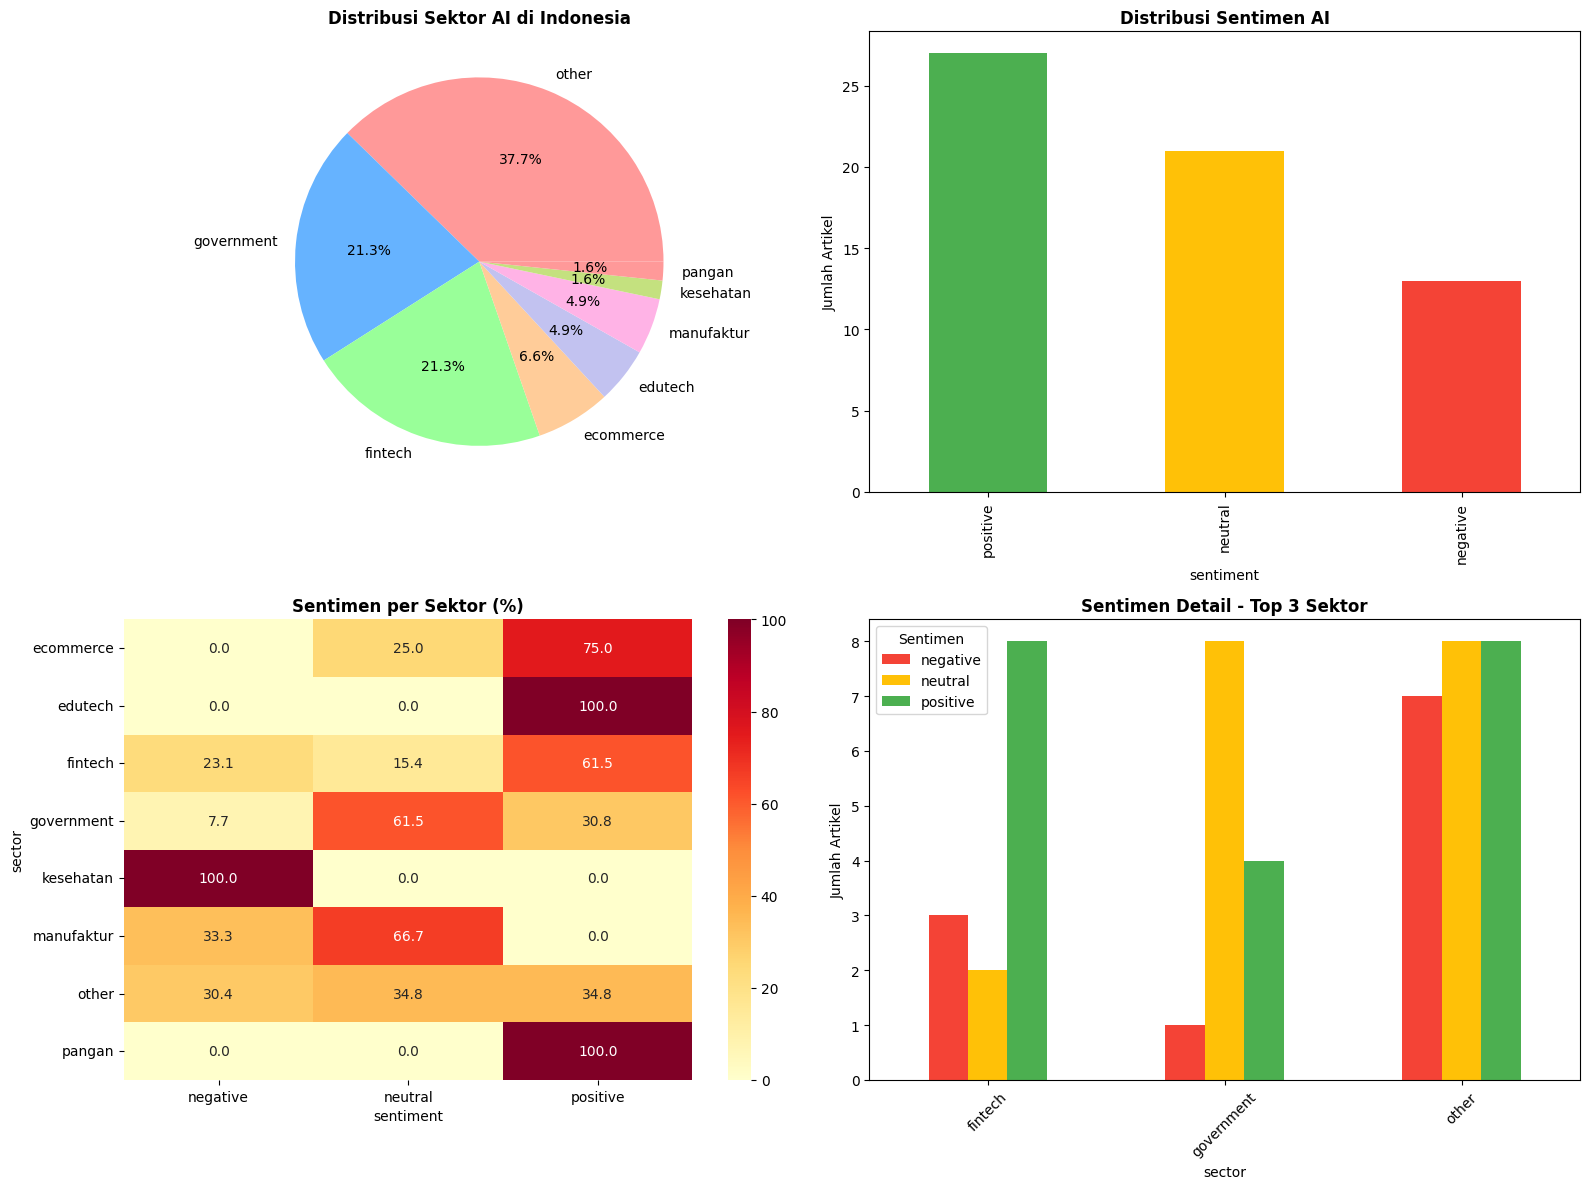

In [ ]:
plt.style.use('default')
plt.rcParams['font.size'] = 10
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Distribusi Sektor (pie chart)
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#c4e17f']
sector_dist.plot(kind='pie', ax=axes[0,0], autopct='%1.1f%%', colors=colors)
axes[0,0].set_title('Distribusi Sektor AI di Indonesia', fontweight='bold')
axes[0,0].set_ylabel('')

# Plot 2: Distribusi Sentimen (bar chart)
sentiment_colors = {'positive': '#4CAF50', 'neutral': '#FFC107', 'negative': '#F44336'}
sentiment_dist.plot(kind='bar', ax=axes[0,1], color=[sentiment_colors.get(s, '#gray') for s in sentiment_dist.index])
axes[0,1].set_title('Distribusi Sentimen AI', fontweight='bold')
axes[0,1].set_ylabel('Jumlah Artikel')

# Plot 3: Sentimen per Sektor (heatmap)
sns.heatmap(sentiment_by_sector, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1,0])
axes[1,0].set_title('Sentimen per Sektor (%)', fontweight='bold')

# Plot 4: Top Sectors Performance
if len(sector_dist) > 0:
    top_sectors = sector_dist.head(3).index
    top_data = final_df[final_df['sector'].isin(top_sectors)]
    sector_sentiment = pd.crosstab(top_data['sector'], top_data['sentiment'])
    sector_sentiment.plot(kind='bar', ax=axes[1,1], color=[sentiment_colors.get(s, 'gray') for s in sector_sentiment.columns])
    axes[1,1].set_title('Sentimen Detail - Top 3 Sektor', fontweight='bold')
    axes[1,1].set_ylabel('Jumlah Artikel')
    axes[1,1].legend(title='Sentimen')
    axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('data/predictions/prediction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# **Cell 13: Pemeriksaan Kualitas Akhir**

In [ ]:
print("\n" + "="*60)
print("QUALITY CHECK FINAL - INFERENCE GRANITE 3.3-8B")
print("="*60)

total_processed = len(final_df)
successful = len(final_df[final_df['error'].isna()])
success_rate = (successful / total_processed) * 100

print(f"📊 METRIK KINERJA:")
print(f"   ✅ Total artikel diproses: {total_processed}")
print(f"   ✅ Artikel berhasil: {successful} ({success_rate:.1f}%)")
print(f"   ❌ Artikel dengan error: {len(errors)}")
print(f"   🎯 Sektor teridentifikasi: {final_df['sector'].nunique()} kategori")
print(f"   😊 Distribusi sentimen: {dict(sentiment_dist)}")

print(f"\n💾 FILE OUTPUT:")
print(f"   📁 Hasil lengkap: {output_file}")
print(f"   📊 Analisis visual: data/predictions/prediction_analysis.png")
print(f"   🔢 Data sektor: data/predictions/predictions_sector.csv")
print(f"   📝 Ringkasan: data/predictions/predictions_summary.csv")
print(f"   😊 Sentimen: data/predictions/predictions_sentiment.csv")

print(f"\n⏱️  STATISTIK PROSES:")
print(f"   📦 Batch size: {BATCH_SIZE}")
print(f"   ⚡ Success rate: {success_rate:.1f}%")
print(f"   🎯 Sektor dominan: {sector_dist.index[0] if len(sector_dist) > 0 else 'N/A'}")

print("\n🎉 INFERENCE DENGAN IBM GRANITE 3.3-8B SELESAI!")
print("Data siap untuk analisis dan visualisasi tahap akhir!")


QUALITY CHECK FINAL - INFERENCE GRANITE 3.3-8B
📊 METRIK KINERJA:
   ✅ Total artikel diproses: 61
   ✅ Artikel berhasil: 61 (100.0%)
   ❌ Artikel dengan error: 0
   🎯 Sektor teridentifikasi: 8 kategori
   😊 Distribusi sentimen: {'positive': np.int64(27), 'neutral': np.int64(21), 'negative': np.int64(13)}

💾 FILE OUTPUT:
   📁 Hasil lengkap: data/predictions/granite_predictions_complete_20251003_094126.csv
   📊 Analisis visual: data/predictions/prediction_analysis.png
   🔢 Data sektor: data/predictions/predictions_sector.csv
   📝 Ringkasan: data/predictions/predictions_summary.csv
   😊 Sentimen: data/predictions/predictions_sentiment.csv

⏱️  STATISTIK PROSES:
   📦 Batch size: 15
   ⚡ Success rate: 100.0%
   🎯 Sektor dominan: other

🎉 INFERENCE DENGAN IBM GRANITE 3.3-8B SELESAI!
Data siap untuk analisis dan visualisasi tahap akhir!
